# Final Project Submission

- Student name: Kristen Tokunaga
- Student pace: part time
- Scheduled project review date/time: 
- Instructor name: Brandon Lewis
- Blog post URL: https://kristentaytok.github.io/

# The Scientific Method

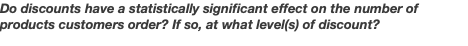

Using data from the Northwind database, we will employ SQL, statistical analysis (hypothesis testing), and the Scientific Method to answer business questions about this fictional company:

1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. Is there a statistically significant difference in performance between employees from the 52 territories?  
3. Does the spend of our top 20% of customers exceed 80% of our sales income of in a given year?
4. Which product categories had significantly higher orders per quarter? 

The process for answering the 4 above questions will be to follow the steps from the Scientific method:
1. Construct hypothesis (null and alternative)
2. Test with an experiment: one-tail or two-tail test
3. Analyze Results: 
- Test statistic
- P-value
- Effect size
4. Conclusion: Reject or fail to reject the hypothesis

# Getting Started

1. Import Necessary Libraries
2. Connect to the Database
3. Explore the Data

In [18]:
#import libraries
import sqlalchemy
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [19]:
#connect using SQLAlchemy, an Object Relational Mapper (ORM) which connects relational database tables to Python objects, and use CRUD: Create, Read, Update, Delete
#create an engine object, and bind it to our database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)

#create an inspector object by passing in engine to inspect
from sqlalchemy import inspect
inspector = inspect(engine)

# get names of tables in database
print(inspector.get_table_names())

#get column names for a specific table, along with each column's datatype
def get_columns_info(table_name):    
    """ Function takes in table name and prints columns' names
    and datatypes """
    
    cols_list = inspector.get_columns(table_name)    
    print(f"Table Name: {table_name}\n")
    for col in cols_list:
        print(f"Name: {col['name']} \t Type: {col['type']}")
              
get_columns_info('OrderDetail')
#https://github.com/BrittaInData/dsc-2-final-project-online-ds-ft-100118/blob/master/01_Final_Notebook.ipynb

2019-06-04 07:47:52,303 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-04 07:47:52,304 INFO sqlalchemy.engine.base.Engine ()
2019-06-04 07:47:52,305 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-04 07:47:52,306 INFO sqlalchemy.engine.base.Engine ()
2019-06-04 07:47:52,307 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-04 07:47:52,308 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']
2019-06-04 07:47:52,310 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-06-04 07:47:52,310 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INT

In [20]:
#explore the data
table_list = ['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']
def all_tables(table_list):
    for table in table_list:
        print(get_columns_info(table))
all_tables(table_list)

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "Northwind_ERD.png")

2019-06-04 07:47:54,669 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-06-04 07:47:54,670 INFO sqlalchemy.engine.base.Engine ()
Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)
None
2019-06-04 07:47:54,672 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-06-04 07:47:54,673 INFO sqlalchemy.engine.base.Engine ()
Table Name: Customer

Name: Id 	 Type: VARCHAR(8000)
Name: CompanyName 	 Type: VARCHAR(8000)
Name: ContactName 	 Type: VARCHAR(8000)
Name: ContactTitle 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)
Name: Fax 	 Type: VARCHAR(8000)
None
2019-06-04 07:47:54,677 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-06-04 07:47:54,678 INFO sqlalchemy.

# Question #1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

1. Construct hypothesis (null and alternative)
- Null: H0 = there is no difference in product quantity per order across all levels of discounts (M1 = M2 = M3 = M4 = M5 = M6 = M7 = M8 = M9 = M10 = M11)
- Alternative: H1 = there is a difference in product quantity per order between at least 2 discount levels (M1 =/= M2 and/or M3, etc.; M2 =/= M3 and/or M4, etc.) 
2. Test with an experiment: two-tail test (because we want to test if the average product quantity per order at each discount level falls between, or outside of, a range of two given values; in short, we are testing for any difference [more or fewer products per order] among the discount levels.  
- ANOVA  (ANalysis Of VAriance) = a statistical test for multiple groups (multiple pairwise comparisons). ANOVA describes overall variation from all of our sample observations, and break this variation down to variation from each of these individual factors [Sum of Square of Deviations. or the variance between mean of each sample group to the observations within the group itself] vs. unaccounted-for error or chance [Sum of Square of Errors, or the variance between mean of these test groups to the mean of all observations].    
3. Analyze Results: 
- Test statistic = F-distribution, which results from comparing the SSD and SSE. Higher values of the F-statistic indicate a higher probability of that factor being influential.
- P-value
- Effect size
4. Conclusion: Reject or fail to reject the hypothesis

In [44]:
df2 = pd.read_sql_query('''SELECT * FROM Territory''', engine)
df2.TerritoryDescription.unique()

2019-06-04 15:22:47,112 INFO sqlalchemy.engine.base.Engine SELECT * FROM Employee
2019-06-04 15:22:47,112 INFO sqlalchemy.engine.base.Engine ()
2019-06-04 15:22:47,117 INFO sqlalchemy.engine.base.Engine SELECT * FROM Territory
2019-06-04 15:22:47,118 INFO sqlalchemy.engine.base.Engine ()


array(['Westboro', 'Bedford', 'Georgetow', 'Boston', 'Cambridge',
       'Braintree', 'Providence', 'Hollis', 'Portsmouth', 'Wilton',
       'Morristown', 'Edison', 'New York', 'Mellvile', 'Fairport',
       'Philadelphia', 'Neward', 'Rockville', 'Greensboro', 'Cary',
       'Columbia', 'Atlanta', 'Savannah', 'Orlando', 'Tampa',
       'Louisville', 'Beachwood', 'Findlay', 'Southfield', 'Troy',
       'Bloomfield Hills', 'Racine', 'Roseville', 'Minneapolis',
       'Hoffman Estates', 'Chicago', 'Bentonville', 'Dallas', 'Austin',
       'Denver', 'Colorado Springs', 'Phoenix', 'Scottsdale',
       'Santa Monica', 'Menlo Park', 'San Francisco', 'Campbell',
       'Santa Clara', 'Santa Cruz', 'Bellevue', 'Redmond', 'Seattle'],
      dtype=object)

In [45]:
df = pd.read_sql_query('''SELECT * FROM OrderDetail''', engine)
df.Discount.unique()


2019-06-04 15:31:37,965 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-06-04 15:31:37,966 INFO sqlalchemy.engine.base.Engine ()


array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])